# ANNALISA GPU

**Advanced Non-linear transient-Noise Analyser of Laser Intererometer Sensor Arrays**

## Set Device

In [1]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'
print(f'{device=}')

NVIDIA A100-PCIE-40GB
device='cuda'


## Imports

Check what imports are necessary and eliminate others

In [2]:
import h5py as h5
import os
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
import matplotlib.mlab as mlab
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
from  Peak_finder_torch import * 

In [3]:
try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
from gwpy.signal import filter_design
import time
from tqdm import tqdm
import json
import torch
import multiprocessing
import math
import csv
import time

In [4]:
from qtransform_gpu import * 

<module 'qtransform_delta' from '/home/jovyan/qtransform_delta.py'>

In [5]:
from Annalisa_gpu import * 

NVIDIA A100-PCIE-40GB
Running on device: device='cuda'
NVIDIA A100-PCIE-40GB
Running on device: device='cuda'


<module 'Preprocess' from '/home/jovyan/Preprocess.py'>

In [6]:
from ml4gw.transforms import SpectralDensity,Whiten

## Load data

Load data form local storage as .h5 files 

In [10]:
h5_path_raw='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1_linear_corrs'
target_raw='V1:Hrec_hoft_raw_20000Hz'

In [6]:
h5_path_rec='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1'
target_rec='V1:Hrec_hoft_16384Hz'

In [ ]:
df_raw=construct_dataframe(path=h5_path_raw, channel_list=None, target_channel=target_raw, n1_events=None, n2_events=None, n1_channels=None, n2_channels=None, print_=True, sr=False)

In [ ]:
df_rec=construct_dataframe(path=h5_path_rec, channel_list=CH, target_channel=target_rec, n1_events=None, n2_events=None, n1_channels=None, n2_channels=20, print_=True, sr=False)

In [18]:
df_rec.shape

(11882, 18)

In [13]:
df_rec.head()

,Event ID,V1:Hrec_hoft_16384Hz,V1:ENV_METEO_WIND_DIR,V1:ENV_METEO_WIND_SPD,V1:ENV_NEB_SEIS_N,V1:ENV_NEB_SEIS_V,V1:ENV_NEB_SEIS_W,V1:INJ_IMC_TRA_DC,V1:LSC_DARM_ERR,V1:LSC_MICH_ERR,V1:LSC_NE_CORR,V1:LSC_PRCL_ERR,V1:LSC_PR_CORR,V1:Sa_NE_F0_LVDT_V_500Hz,V1:Sa_NE_F0_TY_500Hz,V1:Sa_NE_F0_X_500Hz,V1:Sa_NE_F0_Z_500Hz,V1:Sc_MC_MIR_Z_CORR
0,DdncGnx3ph,[TimeSeries(-2.29567063e-18\n unit: ...,[TimeSeries(14.15\n unit: dimensionl...,[TimeSeries(44.672\n unit: dimension...,[TimeSeries(5077.54\n unit: dimensio...,[TimeSeries(1704.15\n unit: dimensio...,[TimeSeries(2530.73\n unit: dimensio...,[TimeSeries(-268441.45639626\n unit:...,[TimeSeries(-4.1042317e-06\n unit: d...,[TimeSeries(0.5400074\n unit: dimens...,[TimeSeries(1.7821774\n unit: dimens...,[TimeSeries(2.6768015e-05\n unit: di...,[TimeSeries(4.2447248\n unit: dimens...,[TimeSeries(-260.73352\n unit: dimen...,[TimeSeries(-0.16767003\n unit: dime...,[TimeSeries(0.43042922\n unit: dimen...,[TimeSeries(-161.22325\n unit: dimen...,[TimeSeries(-0.85617304\n unit: dime...
1,F5TczvmxTN,[TimeSeries(-5.89375989e-20\n unit: ...,[TimeSeries(148.\n unit: dimensionle...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(5150.53\n unit: dimensio...,[TimeSeries(1654.94\n unit: dimensio...,[TimeSeries(2428.08\n unit: dimensio...,[TimeSeries(-262367.38080751\n unit:...,[TimeSeries(3.4738642e-07\n unit: di...,[TimeSeries(0.06838007\n unit: dimen...,[TimeSeries(-0.17641005\n unit: dime...,[TimeSeries(1.8503602e-05\n unit: di...,[TimeSeries(-0.00083549\n unit: dime...,[TimeSeries(-259.9595\n unit: dimens...,[TimeSeries(0.06821006\n unit: dimen...,[TimeSeries(-0.09688703\n unit: dime...,[TimeSeries(-10.292362\n unit: dimen...,[TimeSeries(-0.08829498\n unit: dime...
2,GuH8LYoP65,[TimeSeries(-5.47180623e-20\n unit: ...,[TimeSeries(241.69\n unit: dimension...,[TimeSeries(26.464\n unit: dimension...,[TimeSeries(5244.53\n unit: dimensio...,[TimeSeries(1261.85\n unit: dimensio...,[TimeSeries(1511.39\n unit: dimensio...,[TimeSeries(-253709.67078142\n unit:...,[TimeSeries(2.5354979e-07\n unit: di...,[TimeSeries(0.02219082\n unit: dimen...,[TimeSeries(-0.5015571\n unit: dimen...,[TimeSeries(4.6051455e-06\n unit: di...,[TimeSeries(-0.6472094\n unit: dimen...,[TimeSeries(-259.8319\n unit: dimens...,[TimeSeries(-0.2634932\n unit: dimen...,[TimeSeries(3.062007\n unit: dimensi...,[TimeSeries(-32.586617\n unit: dimen...,[TimeSeries(0.02153816\n unit: dimen...
3,dySNb3H9q7,[TimeSeries(7.41643571e-19\n unit: d...,[TimeSeries(271.7\n unit: dimensionl...,[TimeSeries(21.168\n unit: dimension...,[TimeSeries(5459.84\n unit: dimensio...,[TimeSeries(1449.05\n unit: dimensio...,[TimeSeries(2178.94\n unit: dimensio...,[TimeSeries(-255786.40338452\n unit:...,[TimeSeries(4.8717357e-07\n unit: di...,[TimeSeries(0.07807747\n unit: dimen...,[TimeSeries(-0.3615009\n unit: dimen...,[TimeSeries(-1.3233277e-05\n unit: d...,[TimeSeries(0.09987321\n unit: dimen...,[TimeSeries(-260.24353\n unit: dimen...,[TimeSeries(0.07252145\n unit: dimen...,[TimeSeries(0.12821229\n unit: dimen...,[TimeSeries(33.280964\n unit: dimens...,[TimeSeries(0.58094287\n unit: dimen...
4,gPrBiWcNey,[TimeSeries(-2.34829179e-20\n unit: ...,[TimeSeries(63.989998\n unit: dimens...,[TimeSeries(19.568\n unit: dimension...,[TimeSeries(4848.96\n unit: dimensio...,[TimeSeries(1654.9\n unit: dimension...,[TimeSeries(2969.01\n unit: dimensio...,[TimeSeries(-262100.85391804\n unit:...,[TimeSeries(8.0945966e-08\n unit: di...,[TimeSeries(0.12571496\n unit: dimen...,[TimeSeries(0.15518437\n unit: dimen...,[TimeSeries(2.6477462e-06\n unit: di...,[TimeSeries(-0.36763057\n unit: dime...,[TimeSeries(-260.2262\n unit: dimens...,[TimeSeries(0.05228283\n unit: dimen...,[TimeSeries(-1.8886545\n unit: dimen...,[TimeSeries(59.529575\n unit: dimens...,[TimeSeries(0.1747001\n unit: dimens...


In [17]:
df_raw.shape

(11333, 16)

In [35]:
df_raw.head()

,Event ID,V1:Hrec_hoft_raw_20000Hz,V1:LSC_CARM,V1:LSC_CARM_CORR,V1:LSC_CARM_ERR,V1:LSC_CARM_NOISE,V1:LSC_DARM,V1:LSC_DARM_CORR,V1:LSC_DARM_NOISE,V1:LSC_MICH,V1:LSC_MICH_CORR,V1:LSC_MICH_NOISE,V1:LSC_PRCL,V1:LSC_PRCL_CORR,V1:LSC_PRCL_ERR,V1:LSC_PRCL_NOISE
0,J2yIBIg08H,[TimeSeries(2.6208163e-19\n unit: di...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(1.2349406e-06\n unit: di...,[TimeSeries(-0.98789257\n unit: dime...,[TimeSeries(9.704231e-10\n unit: dim...,[TimeSeries(-0.0247214\n unit: dimen...,[TimeSeries(0.25829658\n unit: dimen...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(1.4526501e-05\n unit: di...,[TimeSeries(-0.22812983\n unit: dime...,[TimeSeries(1.4526501e-05\n unit: di...,[TimeSeries(0.\n unit: dimensionless...
1,YBjpyixbjw,[TimeSeries(5.13095e-20\n unit: dime...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(4.3513512e-07\n unit: di...,[TimeSeries(0.87965035\n unit: dimen...,[TimeSeries(-8.1330215e-10\n unit: d...,[TimeSeries(0.08612892\n unit: dimen...,[TimeSeries(0.29637858\n unit: dimen...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(1.6866796e-05\n unit: di...,[TimeSeries(-0.20654573\n unit: dime...,[TimeSeries(1.6866796e-05\n unit: di...,[TimeSeries(0.\n unit: dimensionless...
2,cs3ZzeVkm6,[TimeSeries(-1.662892e-19\n unit: di...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(-8.222554e-08\n unit: di...,[TimeSeries(0.62270653\n unit: dimen...,[TimeSeries(-3.4552758e-10\n unit: d...,[TimeSeries(0.00088814\n unit: dimen...,[TimeSeries(-0.15669861\n unit: dime...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(3.683751e-06\n unit: dim...,[TimeSeries(-0.14784397\n unit: dime...,[TimeSeries(3.683751e-06\n unit: dim...,[TimeSeries(0.\n unit: dimensionless...
3,Ot07uGid3J,[TimeSeries(-1.1273905e-18\n unit: d...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(-1.75163e-06\n unit: dim...,[TimeSeries(0.10104641\n unit: dimen...,[TimeSeries(-8.13302e-10\n unit: dim...,[TimeSeries(-0.05311267\n unit: dime...,[TimeSeries(-0.36259654\n unit: dime...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(2.4482491e-05\n unit: di...,[TimeSeries(-0.00999739\n unit: dime...,[TimeSeries(2.4482491e-05\n unit: di...,[TimeSeries(0.\n unit: dimensionless...
4,U2xyBDwfrz,[TimeSeries(-6.840366e-20\n unit: di...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(-4.3780318e-07\n unit: d...,[TimeSeries(-0.6388988\n unit: dimen...,[TimeSeries(-1.7333737e-09\n unit: d...,[TimeSeries(-0.03087924\n unit: dime...,[TimeSeries(-0.40519664\n unit: dime...,[TimeSeries(0.\n unit: dimensionless...,[TimeSeries(3.8032267e-05\n unit: di...,[TimeSeries(-0.0844243\n unit: dimen...,[TimeSeries(3.8032267e-05\n unit: di...,[TimeSeries(0.\n unit: dimensionless...


## Preprocess

Apply resampling and cropping to data. We need our input to be of the same length and same sample rate.

The default parameter for prerprocessing should be:
- time series length 6s 
- sample rate 1024 Hz.
- band filtering [8,500] Hz
- no whitening 

In [ ]:
s=time.time()
df_rec.iloc[:,1:]=apply_parallel_inplace_generic(
        preprocess_timeseries,
        df_rec.iloc[:,1:],
        whiten=False,
        band_filter=[8,500],
        duration=6,
    )
e=time.time()
print(f'Time elapsed: {e-s} s')

In [ ]:
s=time.time()
df_raw.iloc[:,1:]=apply_parallel_inplace_generic(
        preprocess_timeseries,
        df_rec.iloc[:,1:],
        whiten=False,
        band_filter=[80,500],
        duration=False,
    )
e=time.time()
print(f'Time elapsed: {e-s} s')

Convert df entries to torch-tensors (this step won't be needed when datais loaded as torch tensor)

In [25]:
#update this using parallel inplace
df_rec_torch=process_data_one_by_one(df_rec_prova,torch.tensor)
df_rec_torch=process_data_one_by_one(df_rec_prova,torch.tensor)

In [ ]:
#Save memory
del df_rec
del df_torch

Merge dataframes based on Event id. This step needs to be upgraded to torch tensors

In [ ]:
df = pd.merge(df_raw_torch, df_rec_torch, on='Event ID')

Convert pandas to torch tensor

In [ ]:
data=convert_to_torch(df.iloc[:,1:])

Save dataset. In script allow user to save preprocessed dataset as .pt

In [ ]:
out_dir='abc'
save_name='123'
torch.save(data, f'{out_dir}/{save_name}.pt') 

## ANNALISA SCAN

The script should allow for the possibility of bypassing the data loading from .h5 and/or preprocessing directly loading a torch tensor (or a pandas that then needs to be converted to torch tensor)

In [7]:
# to directly load torch tensor
file_path='/data/notebooks_intertwin/Merged_Dataset_Hraw&Hrec.pt'
#file_path='/data/notebooks_intertwin/Merged_Dataset_Hraw&Hrec_Whitened&Sampled.pt'
data = torch.load(file_path)
# for pandas
#df=pd.read_pickle(file_path)
#then apply conversion as shown above

In [8]:
data.shape

torch.Size([8740, 26, 24576])

Move data to Dataloader before feeding to ANNALISA.

In [20]:
event_batch_size = 20
channel_batch_size = 26
strain_dataloader = DataLoader(
    data[:,0,:],
    batch_size=event_batch_size,
)
aux_dataloader = NestedMultiDimBatchDataLoader(data[:,:,:], event_batch_size, channel_batch_size)

In [10]:
class Annalisa(nn.Module):
    def __init__(self, ts_length, sample_rate, device='cpu', threshold=20, time_window=None, time_only_mode=False,
                 tolerance_distance=0, q=12, frange=[10, 50], fres=0.5, tres=0.1, num_t_bins=None, num_f_bins=None,
                 logf=False, qtile_mode=False,whiten=False):
        super(Annalisa, self).__init__()
        # Set device
        self.device = device

        # Scanner parameters
        self.threshold = threshold
        self.time_window = time_window
        self.time_only_mode = time_only_mode
        self.tolerance_distance = tolerance_distance
        
        # whitening parameters
        self.whiten=whiten
        print(f'{self.whiten=}')
        if whiten:
            self.fftlength = 2
            self.sample_rate=sample_rate

            self.spectral_density = SpectralDensity(
                sample_rate=self.sample_rate,
                fftlength=self.fftlength,
                overlap=None,
                average="median",
            ).to(self.device)
            
            self.fduration=2
            self.whitening = Whiten(
                fduration=self.fduration,
                sample_rate=self.sample_rate,
                highpass=None
            ).to(device)

            

        # QT parameters
        self.length = ts_length
        self.sample_rate = sample_rate
        if whiten:
            self.duration= ts_length / sample_rate - self.fduration
        else:
            self.duration = ts_length / sample_rate
        print(f'{self.duration=}')
        self.q = q
        self.frange = frange
        self.tres = tres
        self.fres = fres
        self.num_t_bins = num_t_bins or int(self.duration / tres)
        self.num_f_bins = num_f_bins or int((frange[1] - frange[0]) / fres)
        self.logf = logf
        self.qtile_mode = qtile_mode

        # Initialize Q-transform
        self.qtransform = SingleQTransform(
            sample_rate=self.sample_rate,
            duration=self.duration,
            q=self.q,
            frange=self.frange,
            spectrogram_shape=(self.num_t_bins, self.num_f_bins),
            logf=self.logf,
            qtiles_mode=self.qtile_mode
        ).to(self.device)
        
        
        #derivatives peak detection

    def forward(self, strain_batch, aux_batch):
        # Compute Q-transform of input data
        if self.whiten:
            #print(f'Before Whiten: {strain_batch.shape=}')
            strain_psd=self.spectral_density(strain_batch.double().to(device))
            #print(f'{strain_psd.shape=}')
            strain_batch = self.whitening(strain_batch.double().to(device), strain_psd)
            #print(f'After Whiten: {strain_batch.shape=}')
            
        qt_strain = self.qtransform(strain_batch.to(self.device))
        #print(f'{qt_strain.shape=}')
        peaks_strain = self.peaks_from_qt_torch(qt_strain, threshold=self.threshold)

        # Correlation coefficients for auxiliary batches
        corr_coeffs = []
        iou_coeffs = []
        for child_aux_batch in aux_batch.child_batches():
            
            if self.whiten:
                aux_psd=self.spectral_density(child_aux_batch.double().to(device))
                child_aux_batch = self.whitening(child_aux_batch.double().to(device), aux_psd)
                #print(f'{aux_psd.shape=}')
                
            qt_aux = self.qtransform(child_aux_batch.to(self.device))
            peaks_aux = self.peaks_from_qt_torch(qt_aux, threshold=self.threshold)
            iou_coeff,corr_coeff = self.compute_ratio(peaks_strain, peaks_aux)
            corr_coeffs.append(corr_coeff)
            iou_coeffs.append(iou_coeff)

        return torch.cat(iou_coeffs, dim=-1).detach().cpu(),torch.cat(corr_coeffs, dim=-1).detach().cpu()

    def peaks_from_qt_torch(self, batch, threshold=25):
        clamped_data = torch.clamp(batch, min=0)
        peaks, _ = find_peaks_torch(clamped_data.flatten(), height=threshold)
        peaks_2d = self.torch_unravel_index(peaks, clamped_data.shape)

        # Create a mask for the detected peaks
        mask = torch.zeros(clamped_data.shape, dtype=torch.bool, device=clamped_data.device)
        mask.index_put_(tuple(peaks_2d.t()), torch.ones(peaks_2d.size(0), dtype=torch.bool, device=clamped_data.device))
        return mask

    def torch_unravel_index(self, indices, shape):
        unraveled_indices = []
        for dim in reversed(shape):
            unraveled_indices.append(indices % dim)
            indices = indices // dim
        return torch.stack(list(reversed(unraveled_indices)), dim=-1)

    def compute_ratio(self, mask1, mask2):
        if self.time_only_mode:
            # Collapse masks along the frequency axis (y-axis)
            mask1 = mask1.any(dim=-2)  # Collapse along frequency axis
            mask2 = mask2.any(dim=-2)  # Collapse along frequency axis

            # Update dimension for summing true elements
            intersection = (mask1 & mask2).sum(dim=-1).float()  # Overlap count per batch (time axis only)
            mask1_count = mask1.sum(dim=-1).float()  # Count in mask1 (time axis only)
            mask2_count = mask2.sum(dim=-1).float()  # Count in mask2 (time axis only)
        else:
            # Compute overlap between masks (full 2D)
            intersection = (mask1 & mask2).sum(dim=(-2, -1)).float()  # Overlap count per batch
            mask1_count = mask1.sum(dim=(-2, -1)).float()  # Count in mask1
            mask2_count = mask2.sum(dim=(-2, -1)).float()  # Count in mask2
            
        #print(f'{mask1_count=}')

        # Calculate Jaccard index (intersection over union)
        union = mask1_count + mask2_count - intersection
        jaccard = intersection / union
        ratio= intersection/mask1_count

        # Handle edge case where intersection and union are zero
        zero_union_mask = (intersection == 0) & (union == 0)
        ratio[zero_union_mask] = 1.0
        jaccard[zero_union_mask] = 1.0


        return torch.nan_to_num(jaccard, nan=0.0),torch.nan_to_num(ratio, nan=0.0)  # Handle cases where union is zero


In [27]:
annalisa_scan=Annalisa(24576,4096,device=device,time_only_mode=False,whiten=True).to(device)

self.whiten=True
self.duration=4.0


In [28]:
torch.cuda.empty_cache()


In [29]:
s=time.time()
stacked_corr_coeffs = []
stacked_iou_coeffs = []
#iter=0
for batch_s, batch_a in zip(strain_dataloader,aux_dataloader):
    #print('###############################################################')
    #print(f'{iter=}')
    iou_coeff_batch,corr_coeff_batch=annalisa_scan(batch_s, batch_a)
    stacked_iou_coeffs.append(iou_coeff_batch)  # Append corr_coeff to the list 
    stacked_corr_coeffs.append(corr_coeff_batch)  # Append corr_coeff to the list  
    #iter+=1
corr_coeff_dataset=torch.cat(stacked_corr_coeffs, dim=0)
iou_coeff_dataset=torch.cat(stacked_iou_coeffs, dim=0)
e=time.time()
print(f'Time elapsed: {e-s}s')
corr_coeff_dataset.shape

Time elapsed: 28.029877424240112s


torch.Size([8740, 26])

In [30]:
torch.mean(corr_coeff_dataset,axis=0)

tensor([1.0000, 0.0174, 0.4218, 0.4633, 0.3165, 0.1947, 0.3991, 0.3076, 0.3991,
        0.1430, 0.0158, 0.0157, 0.0696, 0.0705, 0.0697, 0.0691, 0.3075, 0.4857,
        0.4047, 0.3989, 0.4082, 0.0710, 0.0716, 0.0708, 0.0721, 0.0119])

In [31]:
torch.mean(iou_coeff_dataset,axis=0)

tensor([1.0000, 0.0029, 0.1532, 0.2210, 0.0891, 0.0424, 0.1606, 0.2376, 0.1606,
        0.1136, 0.0084, 0.0078, 0.0696, 0.0705, 0.0697, 0.0687, 0.2379, 0.2550,
        0.1525, 0.1602, 0.1873, 0.0710, 0.0716, 0.0708, 0.0721, 0.0083])

In [32]:
column_list=['V1:Hrec_hoft_raw_20000Hz', 'V1:LSC_DARM_NOISE', 'V1:LSC_PRCL',
       'V1:LSC_DARM_CORR', 'V1:LSC_PRCL_CORR', 'V1:LSC_MICH',
       'V1:LSC_PRCL_ERR_x', 'V1:LSC_DARM', 'V1:LSC_MICH_CORR',
       'V1:Hrec_hoft_16384Hz', 'V1:ENV_METEO_WIND_DIR',
       'V1:ENV_METEO_WIND_SPD', 'V1:ENV_NEB_SEIS_N', 'V1:ENV_NEB_SEIS_V',
       'V1:ENV_NEB_SEIS_W', 'V1:INJ_IMC_TRA_DC', 'V1:LSC_DARM_ERR',
       'V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR', 'V1:LSC_PRCL_ERR_y',
       'V1:LSC_PR_CORR', 'V1:Sa_NE_F0_LVDT_V_500Hz', 'V1:Sa_NE_F0_TY_500Hz',
       'V1:Sa_NE_F0_X_500Hz', 'V1:Sa_NE_F0_Z_500Hz', 'V1:Sc_MC_MIR_Z_CORR']

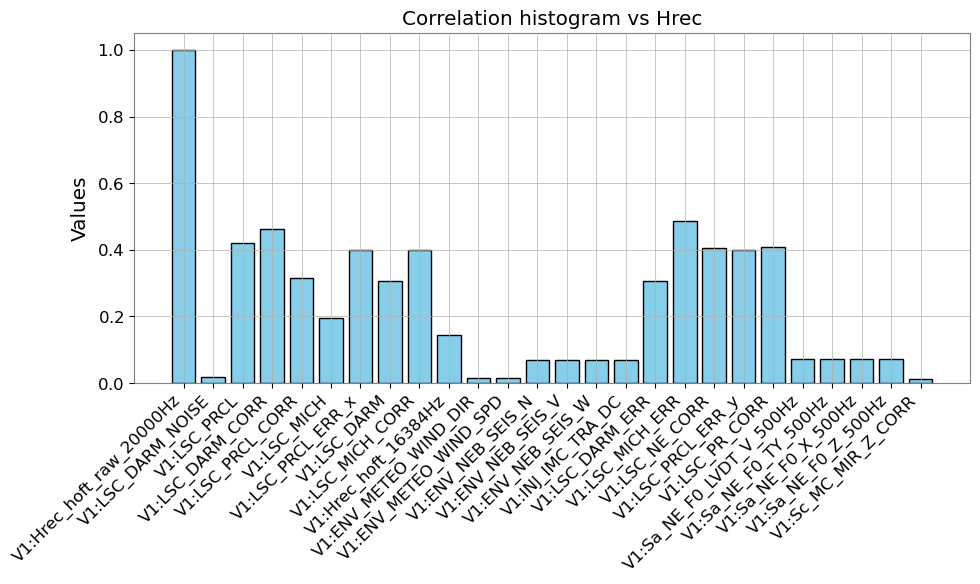

In [33]:
plot_histogram(column_list, torch.mean(corr_coeff_dataset,axis=0), title='Correlation histogram vs Hrec')

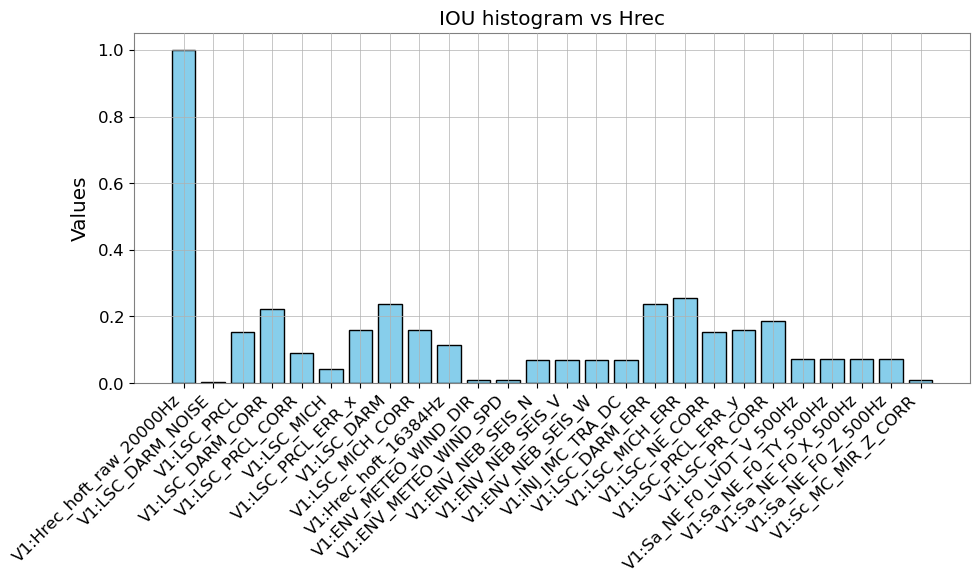

In [34]:
plot_histogram(column_list, torch.mean(iou_coeff_dataset,axis=0), title='IOU histogram vs Hrec')

In [40]:
#indices_to_select = [0, 2, 4,5, 6,8, 17, 19, 20]
threshold_corr=0.17
threshold_iou=0.08
mask=(torch.mean(corr_coeff_dataset,axis=0)>threshold_corr) & (torch.mean(iou_coeff_dataset,axis=0)>threshold_iou)
indices_to_select = torch.nonzero(mask)
print(indices_to_select)

selected_elements = [column_list[i] for i in indices_to_select]

print(selected_elements)

tensor([[ 0],
        [ 2],
        [ 3],
        [ 4],
        [ 6],
        [ 7],
        [ 8],
        [16],
        [17],
        [18],
        [19],
        [20]])
['V1:Hrec_hoft_raw_20000Hz', 'V1:LSC_PRCL', 'V1:LSC_DARM_CORR', 'V1:LSC_PRCL_CORR', 'V1:LSC_PRCL_ERR_x', 'V1:LSC_DARM', 'V1:LSC_MICH_CORR', 'V1:LSC_DARM_ERR', 'V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR', 'V1:LSC_PRCL_ERR_y', 'V1:LSC_PR_CORR']


Filter the dataset given the results of the annalisa scan 

In [ ]:
#Save channel index list
in_dir='/home/jovyan/Timeseries Dataset'
save_name='ch'
torch.save(indices_to_select,f'{in_dir}/{save_name}.pt')